<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Numerical-Optimization" data-toc-modified-id="Numerical-Optimization-1">Numerical Optimization</a></span><ul class="toc-item"><li><span><a href="#Problem-set-3-(14-points)" data-toc-modified-id="Problem-set-3-(14-points)-1.1">Problem set 3 (14 points)</a></span></li><li><span><a href="#Bonus-(4-points)" data-toc-modified-id="Bonus-(4-points)-1.2">Bonus (4 points)</a></span></li></ul></li></ul></div>

Rafał Nowak
# Numerical Optimization
## Problem set 3 (14 points)

**Submission deadline**: Thursday, 02.02.2022

* All submissions should contain single file.<br/>This can be single Jupyter notebook file (with extension `ipynb`) or ZIP archive in case the are some additional files needed.
* It is recommended to write the reports using LaTeX. 
* One can report the answers, comments and results in PDF or notebook file.
* All the source code should be written in Python or Julia.

In [101]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pandas as pd

**Problem 5.1** (total 8 pts)

(2 pts) Complete the implementation of Newton's method (see [Boyd, *Convex Optimization*, $\S 9.5.2$])
<img src="https://i.ibb.co/RvqY16d/Boyd-Newton-method.png" alt="Boyd-Newton-method">


In [2]:
COUNT_EVALS = 0

In [3]:
def exact_line_search(f, x, direction, iterations, epsilon=10e-10, s=1e-2, k=2.0):
    global COUNT_EVALS
    def find_initial_bracket(f, s=1e-2, k=2.0):
        global COUNT_EVALS
        v = f(0)
        t1 = 0
        while v > 0:
            t1 += s
            s *= k
            v = f(t1)
        
        t2 = t1
        while v < 0:
            t1 = t2
            t2 += s
            s *= k
            v = f(t2)
        return t1, t2
  
    def g(t):
        global COUNT_EVALS
        COUNT_EVALS += 1
        return f(x + t*direction, order=1)[1].T @ direction
    
    def bisection(f, t1, t2, epsilon):
        global COUNT_EVALS
        mid = (t1+t2)/2
        v = f(mid)
        while (t2-t1) > epsilon:
            if v < 0:
                t1 = mid
            else:
                t2 = mid
            mid = (t1+t2)/2
            v = f(mid)
        return (t1+t2)/2

    t1, t2 = find_initial_bracket(g, s=s, k=k)
    t = bisection(g, t1, t2, epsilon)
    return t

In [4]:
def backtracking(func, x, direction, iterations, alpha, beta):
    global COUNT_EVALS
    t = 1.0
    value, gradient = func( x , order=1 )
    value_x = np.double( value )
    gradient_x = np.matrix( gradient )
    while func(x+t*direction, order=0) > value + alpha*t*gradient_x.T@direction:
        COUNT_EVALS += 1
        t *= beta
    return t

In [41]:
# Remark: Implement bisection method first
def newton(func, initial_x, *linesearch_args, eps=1e-5, maximum_iterations=65536, linesearch=backtracking,
          print_decrement=False):
    """ 
    Newton's Method
    func:               the function to optimize It is called as "value, gradient, hessian = func( x, 2 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """
    
    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )
    
    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    iterations = 0
    
    # Newton's method updates
    while True:
        
        value, gradient, hessian = func( x , order=2 )
        value = np.double( value )
        gradient = np.matrix( gradient )
        hessian = np.matrix( hessian ) 
        
        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )

        ### TODO: Compute the Newton update direction
        direction = - np.linalg.inv(hessian) @ gradient

        ### TODO: Compute the Newton decrement
        newton_decrement = gradient.T @ np.linalg.inv(hessian) @ gradient
        if print_decrement:
            print(newton_decrement)
        

        if newton_decrement / 2 <= eps:   ### TODO: TERMINATION CRITERION
            break
        
        t = linesearch(func, x, direction, iterations, *linesearch_args)

        ### TODO: update x
        x = x + t * direction

        iterations += 1
        if iterations >= maximum_iterations:
            raise ValueError("Too many iterations")
    
    return (x, values, runtimes, xs)

Test your implementation and compare the results for the following functions
* (1 pts) function $$ f(x) = x^4 + 16x^2 + 18(x-4) e^x\qquad (x\in\mathbb R). $$

In [42]:
def f_example(x, order=2):
    value = x**4 + 16 * x**2 + 18 * (x - 4) * np.exp(x)
    if order==0:
        return value
    elif order==1:
        gradient = 4 * x**3 + 32 * x + 18 * np.exp(x) * (x - 3)
        return value, gradient
    elif order==2:
        gradient = 4 * x**3 + 32 * x + 18 * np.exp(x) * (x - 3)
        hessian = 12 * x**2 + 18 * np.exp(x) * (x - 2) + 32
        return value, gradient, hessian
    else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

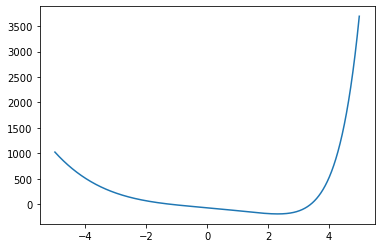

In [43]:
a,b = -5.0, 5.0
xvals = np.linspace(a,b,1000)
yvals = list(map(lambda x: f_example(x, order=0), xvals))
plt.plot(xvals, yvals)

In [44]:
newton(f_example, [1.5],  0.4, 0.9, eps=1e-5, maximum_iterations=65536, linesearch=backtracking)

(matrix([[2.32232497]]),
 [-160.6135081652129,
  -189.84951383040067,
  -192.57004383001936,
  -192.6241500150598,
  -192.624181830695],
 [0.0,
  0.0019943714141845703,
  0.0019943714141845703,
  0.0019943714141845703,
  0.0029914379119873047],
 [array([1.5]),
  matrix([[2.50046563]]),
  matrix([[2.34845971]]),
  matrix([[2.32296334]]),
  matrix([[2.32232497]])])

In [45]:
newton(f_example, [10.0], 10e-5, 1e-2, 2.0, maximum_iterations=65536, linesearch=exact_line_search)

(matrix([[2.32231969]]),
 [2390458.3058391255, -192.62418182884093],
 [0.0, 0.003958940505981445],
 [array([10.]), matrix([[2.32231969]])])

* (1 pt) function `boyd_example_func` written in Python below

In [46]:
def boyd_example_func(x, order=0):
    a=np.matrix('1  3')
    b=np.matrix('1  -3')
    c=np.matrix('-1  0')
    x=np.asmatrix(x)

    value = np.exp(a@x-0.1)[0,0]+np.exp(b@x-0.1)[0,0]+np.exp(c@x-0.1)[0,0]
    if order==0:
        return value
    elif order==1:
        gradient = a.T*np.exp(a@x-0.1)[0,0]+b.T*np.exp(b@x-0.1)[0,0]+c.T*np.exp(c@x-0.1)[0,0]
        return (value, gradient)
    elif order==2:
        gradient = a.T*np.exp(a@x-0.1)[0,0]+b.T*np.exp(b@x-0.1)[0,0]+c.T*np.exp(c@x-0.1)[0,0]
        hessian = a.T@a*np.exp(a@x-0.1)[0,0]+b.T@b*np.exp(b@x-0.1)[0,0]+c.T@c*np.exp(c@x-0.1)[0,0]
        return (value, gradient, hessian)
    else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

In [47]:
newton(boyd_example_func, [[5.0],[5.0]],  0.4, 0.9, eps=1e-5, maximum_iterations=65536, linesearch=backtracking)

(matrix([[-3.46570354e-01],
         [ 2.15728916e-06]]),
 [438995622.7416436,
  161499312.5741365,
  59412163.542642444,
  21856503.10521,
  8040560.07140453,
  2957956.6661045603,
  1088171.4733925308,
  400315.93303926685,
  147268.02857460102,
  54176.91738987129,
  19930.626164446126,
  7332.14028498872,
  2697.445089022108,
  992.4761317380412,
  365.3090942812051,
  134.6653529757698,
  49.92516804145454,
  18.902370956267397,
  7.6977691488430855,
  3.850030487036647,
  2.7462171900764103,
  2.5662933209294745,
  2.5592791266168398,
  2.5592666966984137],
 [0.00099945068359375,
  0.002958536148071289,
  0.002958536148071289,
  0.003957033157348633,
  0.004955291748046875,
  0.005982160568237305,
  0.005982160568237305,
  0.006981611251831055,
  0.007978439331054688,
  0.007978439331054688,
  0.008978843688964844,
  0.008978843688964844,
  0.00994110107421875,
  0.00994110107421875,
  0.010973215103149414,
  0.011967897415161133,
  0.011967897415161133,
  0.012932538986206055,
 

In [48]:
newton(boyd_example_func, [[5.0],[5.0]], 10e-5, 1e-2, 2.0,  eps=1e-5, maximum_iterations=65536, linesearch=exact_line_search)

(matrix([[-0.34683887],
         [ 0.00040362]]),
 [438995622.7416436,
  350639.9076837685,
  2.738081662639273,
  2.5636590971609303,
  2.559267724540552],
 [0.0,
  0.006981849670410156,
  0.011935710906982422,
  0.016921520233154297,
  0.021909713745117188],
 [array([[5.],
         [5.]]),
  matrix([[12.03929433],
          [ 0.17717763]]),
  matrix([[-0.41410411],
          [ 0.17717763]]),
  matrix([[-0.29103812],
          [ 0.00854753]]),
  matrix([[-0.34683887],
          [ 0.00040362]])])

* (2 pts) the following Python function `quadratic` (with different types of matrix $H$)

In [49]:
def quadratic( H, b, x, order=0 ):
    """ 
    Quadratic Objective
    H:          the Hessian matrix
    b:          the vector of linear coefficients
    x:          the current iterate
    order:      the order of the oracle. For example, order=1 returns the value of the function and its gradient while order=2 will also return the hessian
    """
    H = np.asmatrix(H)
    b = np.asmatrix(b)
    x = np.asmatrix(x)
    
    value = 0.5 * x.T @ H @ x + b.T @ x

    if order == 0:
        return value
    elif order == 1:
        gradient = H @ x + b
        return (value, gradient)
    elif order == 2:
        gradient = H @ x + b
        hessian = H
        return (value, gradient, hessian)
    else:
        raise ValueError("The argument \"order\" should be 0, 1 or 2")

In [10]:
def create_quadratic_function(H, b):
    return lambda x, order=0: quadratic(H, b, x, order=order)

In [11]:
def positive_definite(n=4):
    A = np.random.rand(n,n)
    M = A@A.T
    return M

In [12]:
def weakly_positive_definite(n=4):
    eigenvalues = np.random.rand(n)
    D = np.diag(eigenvalues)
    D[0, 0] = 0.0
    P = ortho_group.rvs(dim=n)
    M = P @ D @ P.T
    return M

In [38]:
H = weakly_positive_definite(n=4)
x0 = np.random.rand(4, 1)
b = (H @ x0).reshape(-1, 1)
quad = create_quadratic_function(H, b)
newton(quad, [[5.0],[5.0],[5.0],[5.0]], 10e-5, 1e-2, 2.0,  eps=1e-5, maximum_iterations=65536, linesearch=exact_line_search)

<ipython-input-9-bad7b0023016>:13: RuntimeWarning: overflow encountered in matmul
  value = 0.5 * x.T @ H @ x + b.T @ x
<ipython-input-9-bad7b0023016>:13: RuntimeWarning: invalid value encountered in matmul
  value = 0.5 * x.T @ H @ x + b.T @ x
<ipython-input-3-aafbb3a96a19>:26: RuntimeWarning: overflow encountered in matmul
  return f(x + t*direction, order=1)[1].T @ direction
<ipython-input-3-aafbb3a96a19>:26: RuntimeWarning: invalid value encountered in matmul
  return f(x + t*direction, order=1)[1].T @ direction
<ipython-input-5-2c5e333e8707>:39: RuntimeWarning: invalid value encountered in matmul
  direction = - np.linalg.inv(hessian) @ gradient
<ipython-input-5-2c5e333e8707>:42: RuntimeWarning: invalid value encountered in matmul
  newton_decrement = gradient.T @ np.linalg.inv(hessian) @ gradient


KeyboardInterrupt: 

In [50]:
H = positive_definite(n=4)
b = np.random.rand(4, 1)
quad = create_quadratic_function(H, b)
newton(quad, [[5.0],[5.0],[5.0],[5.0]], 10e-5, 1e-2, 2.0,  eps=1e-5, maximum_iterations=65536, linesearch=exact_line_search)

(matrix([[ 0.26461157],
         [-1.25487787],
         [-0.82585368],
         [ 1.46799317]]),
 [237.56430402456004, -0.38835420476505966],
 [0.0, 0.0010111331939697266],
 [array([[5.],
         [5.],
         [5.],
         [5.]]),
  matrix([[ 0.26461157],
          [-1.25487787],
          [-0.82585368],
          [ 1.46799317]])])

In [51]:
H = np.asmatrix([[1,1],[3,4]]) @ np.asmatrix([[1,1],[3,4]]).T
b = np.asmatrix([[4],[5]])
quad = create_quadratic_function(H, b)
newton(quad, [[5.0],[5.0]], 10e-5, 1e-2, 2.0,  eps=1e-5, maximum_iterations=65536, linesearch=exact_line_search)

(matrix([[-65.00273438],
         [ 18.00050781]]),
 [557.5, -84.99999901962293],
 [0.0, 0.0009975433349609375],
 [array([[5.],
         [5.]]),
  matrix([[-65.00273438],
          [ 18.00050781]])])

In [52]:
H = np.asmatrix([[1,1],[3,4]]) @ np.asmatrix([[1,1],[3,4]]).T
b = np.asmatrix([[4],[5]])
quad = lambda x, order=2: quadratic(H, b, x, order=order)
newton(quad, [[5.0],[5.0]],  0.4, 0.9, eps=1e-5, maximum_iterations=65536, linesearch=backtracking)

(matrix([[-65.],
         [ 18.]]),
 [557.5, -85.0],
 [0.0, 0.0],
 [array([[5.],
         [5.]]),
  matrix([[-65.],
          [ 18.]])])

Newton method finds solutions of convex functions very fast. There was no significant difference between using exact line search and backtracking. Newton finds optimum for strictly positive definite quadratic functions but fails to do so when matrix is weakly positive definite (we may encounter problems with inversions, nans or infinities, which goes on par with theory as hessian is not invertible).

Remark. In `newton` function you should use both `exact_line_search` (1 pt) and `backtracking` (1 pt).

<img width="80%" src="https://i.ibb.co/1fQ0Nfs/Boyd-line-search.png">

---

---

**Problem 5.2** (total 6 pts)

(2 pts) Complete the implementation of Conjugate gradients method (see [Nocedal, Wright, *Numerical Optimization*, $\S 5.2$])

<img src="https://i.ibb.co/Hxn9PmM/Nocedal-Wright-CG-FR.png">

In [97]:
ITERS = 0

In [98]:
def cg_fr( func, initial_x, *linesearch_args, eps=1e-5, maximum_iterations=65536, linesearch=backtracking  ):
    """ 
    Conjugate Gradient
    func:               the function to optimize It is called as "value, gradient = func( x, 1 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """
    
    global COUNT_EVALS
    global ITERS
    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )

    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    m = len( initial_x )
    iterations = 0
    direction = np.asmatrix( np.zeros( x.shape ) )

    # conjugate gradient updates
    while True:
        COUNT_EVALS += 1
        value, gradient = func( x , 1 )
        value = np.double( value )
        gradient = np.asarray( gradient )
        
        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )

        if (gradient.T @ gradient) < eps:  
            break

        # reset after #(dimensions) iterations
        if iterations % m == 0:
            beta = 0
        else:
            beta = ((gradient.T @ gradient) / (old_gradient.T @ old_gradient))[0,0]

        direction = -gradient + beta * direction

        t = linesearch(func, x, direction, iterations, *linesearch_args)

        x += t * direction
        
        old_gradient = gradient

        iterations += 1
        if iterations >= maximum_iterations:
            raise ValueError("Too many iterations")
    ITERS = iterations
    return (x, values, runtimes, xs)

In [99]:
cg_fr(f_example, [[2.0]], 0.4, 0.9, eps=1e-5, maximum_iterations=65536, linesearch=backtracking)

(array([[2.32232979]]),
 [-186.00601956150342,
  -192.1464665653188,
  -192.6221279402406,
  -192.62416255562982,
  -192.62418162773025,
  -192.62418182859264],
 [0.0,
  0.003988504409790039,
  0.007013559341430664,
  0.009007930755615234,
  0.011005401611328125,
  0.013962745666503906],
 [array([[2.]]),
  array([[2.39871719]]),
  array([[2.31718294]]),
  array([[2.32282178]]),
  array([[2.32227355]]),
  array([[2.32232979]])])

Next, copy the function above but use the following Polak-Riberie formulae:
$$ \beta_{k+1}^{\mathtt{PR}} = \frac{\nabla f_{k+1}^T(\nabla f_{k+1} - \nabla f_k)}{\|\nabla f_k\|^2}$$

Observe that we applied the reset trick.
It is worth reading more implementation hints in section [Nocedal, Wright, *Numerical Optimization*, $\S 5.2$].

In [100]:
def cg_pr( func, initial_x, *linesearch_args, eps=1e-5, maximum_iterations=65536, linesearch=backtracking  ):
    """ 
    Conjugate Gradient
    func:               the function to optimize It is called as "value, gradient = func( x, 1 )
    initial_x:          the starting point
    eps:                the maximum allowed error in the resulting stepsize t
    maximum_iterations: the maximum allowed number of iterations
    linesearch:         the linesearch routine
    *linesearch_args:   the extra arguments of linesearch routine
    """
    
    global COUNT_EVALS
    global ITERS
    if eps <= 0:
        raise ValueError("Epsilon must be positive")
    x = np.asarray( initial_x.copy() )

    # initialization
    values = []
    runtimes = []
    xs = []
    start_time = time.time()
    m = len( initial_x )
    iterations = 0
    direction = np.asmatrix( np.zeros( x.shape ) )

    # conjugate gradient updates
    while True:
        COUNT_EVALS += 1
        value, gradient = func( x , 1 )
        value = np.double( value )
        gradient = np.asarray( gradient )

        # updating the logs
        values.append( value )
        runtimes.append( time.time() - start_time )
        xs.append( x.copy() )

        if (gradient.T @ gradient) < eps:
            break

        # reset after #(dimensions) iterations
        if iterations % m == 0:
            beta = 0
        else:
            beta = ((gradient.T @ (gradient - old_gradient)) / (old_gradient.T @ old_gradient))[0,0]

        direction = -gradient + beta * direction

        t = linesearch(func, x, direction, iterations, *linesearch_args)

        x += t * direction
        
        old_gradient = gradient
        old_value = value

        iterations += 1
        if iterations >= maximum_iterations:
            raise ValueError("Too many iterations")
    
    ITERS = iterations
    return (x, values, runtimes, xs)

In [56]:
cg_pr(f_example, [[2.0]],  0.4, 0.9, eps=1e-5, maximum_iterations=65536, linesearch=backtracking)

(array([[2.32232979]]),
 [-186.00601956150342,
  -192.1464665653188,
  -192.6221279402406,
  -192.62416255562982,
  -192.62418162773025,
  -192.62418182859264],
 [0.0,
  0.0019981861114501953,
  0.0059850215911865234,
  0.008975982666015625,
  0.011969327926635742,
  0.013965368270874023],
 [array([[2.]]),
  array([[2.39871719]]),
  array([[2.31718294]]),
  array([[2.32282178]]),
  array([[2.32227355]]),
  array([[2.32232979]])])


(4 pts) Compare the efficiency (number of function/gradient evaluations) of FR and PR updates in CG method for Powell's optimization problem (PSF):
$$ \min_{-10 \leq x_i \leq 10} (x_1+10x_2)^2+5(x_3-x_4)^2+(x_2-2x_3)^4 + 10(x_1-x_4)^4,$$


Observe that $f(X^*)=0$ for $X^*=0$.

More info about PSF can be found, for example, here http://www.optimization-online.org/DB_FILE/2012/03/3382.pdf.

Compare your results with [Nocedal, Wright, *Numerical Optimization*, Table 5.1] (row XPOWELL)
<img width=50% src="https://i.ibb.co/6PVGJrS/Table51.png">

In [57]:
def psf(x, order=1):
    x = np.array(x)
    x1,x2,x3,x4 = x[:,0]
    value = (x1 + 10*x2)**2 + 5*(x3 - x4)**2 + (x2 - 2*x3)**4 + 10*(x1 - x4)**4
    if order==0:
        return value
    elif order==1:
        d1 = 2*(x1 + 10*x2) + 40*(x1 - x4)**3
        d2 = 20*(x1 + 10*x2) + 4*(x2 - 2*x3)**3
        d3 = 10*(x3 - x4) - 8*(x2 - 2*x3)**3
        d4 = -10*(x3 - x4) - 40*(x1 - x4)**3
        gradient = np.array([[d1], [d2], [d3], [d4]])
        return value, gradient
    else:
        raise ValueError("The argument \"order\" should be 0 or 1")

In [133]:
def compare_performance(n_trials=20):
    global COUNT_EVALS
    global ITERS
    results = pd.DataFrame({"Algorithm": [], "trial": [], "iterations": [], "evaluations": []})
    for i in range(n_trials):
        startx = np.random.rand(4, 1)*10
        COUNT_EVALS = 0
        ITERS = 0
        _ = cg_fr(psf, startx, 10e-5, 1e-2, 2.0,  eps=1e-5, maximum_iterations=65536, linesearch=exact_line_search)
        results = results.append({"Algorithm": "FR", "trial": i, "iterations": ITERS, "evaluations": COUNT_EVALS},
                                ignore_index=True)
        
        COUNT_EVALS = 0
        ITERS = 0
        _ = cg_pr(psf, startx, 10e-5, 1e-2, 2.0,  eps=1e-5, maximum_iterations=65536, linesearch=exact_line_search)
        results = results.append({"Algorithm": "PR", "trial": i, "iterations": ITERS, "evaluations": COUNT_EVALS},
                                ignore_index=True)
    return results

In [137]:
n_trials = 100
df = compare_performance(n_trials=n_trials).set_index(["trial", "Algorithm"])
df

iterations  evaluations
trial Algorithm                         
0.0   FR               26.0        365.0
      PR               38.0        515.0
1.0   FR               40.0        575.0
      PR               46.0        643.0
2.0   FR               42.0        603.0
...                     ...          ...
97.0  PR               46.0        647.0
98.0  FR               26.0        363.0
      PR               40.0        583.0
99.0  FR               25.0        358.0
      PR               21.0        296.0

[200 rows x 2 columns]

In [138]:
df.groupby(level=[1]).mean()

,iterations,evaluations
Algorithm,,
FR,35.60,502.16
PR,33.75,477.83


We can see that PR version of CG on average requires a bit less iterations and function evaluations than FR version.

---

## Bonus (4 points)

**Problem 5.3 (2 pts)**
Show experimentally that affine invariance of Newton's method. 

Let $f:\mathbb{R}^n\to\mathbb{R}$ be a convex function.
Consider an affine transform $y\mapsto Ay + b$, where $A \in \mathbb{R}^{n\times n}$ is invertible and
$b \in \mathbb R^n$.

Define the function $g : \mathbb R^n \mapsto \mathbb{R}$ by $g(y) = f(Ay + b)$.
Denote by $x^{(k)}$ the k-th iterate of Newton’s method performed on $f$.
Denote by $y^{(k)}$ the k-th iterate of Newton’s method performed on $g$.
* Show that if $x^{(k)} = Ay^{(k)} + b$, then $x^{(k+1)} = Ay^{(k+1)} + b$.
* Show that Newton's decrement does not depend on the coordinates, i.e., show that $λ(x^{(k)}) = λ(y^{(k)} ).$

Together, this implies that Newton’s method is affine invariant. As an important consequence,
Newton’s method cannot be improved by a change of coordinates, unlike gradient descent.

In [20]:
def transform_f(f, A, b):
    def g(y, order=0):
        if order==0:
            return f(A@y+b, order=0)
        elif order==1:
            value, gradient = f(A@y+b, order=1)
            gradient = A.T @ gradient
            return (value, gradient)
        elif order==2:
            value, gradient, hessian = f(A@y+b, order=2)
            gradient = A.T @ gradient
            hessian = A.T @ hessian @ A
            return (value, gradient, hessian)
        else:
            raise ValueError("The argument \"order\" should be 0, 1 or 2")
    return g

def experiment(f, A, b, y0):
    x0 = A @ y0 + b
    g = transform_f(f, A, b)
    print("\nNewton's decrement of f:")
    x, x_values, x_runtimes, xs = newton(f, x0,  10e-5, 1e-2, 2.0,  eps=1e-5, 
                                         maximum_iterations=65536, linesearch=exact_line_search,
                                         print_decrement=True)
    print("\nNewton's decrement of g:")
    y, y_values, y_runtimes, ys = newton(g, y0,  10e-5, 1e-2, 2.0,  eps=1e-5, 
                                         maximum_iterations=65536, linesearch=exact_line_search,
                                         print_decrement=True)
    return xs, ys

y0 = np.array([[3.0], [2.0]])
A = np.random.rand(2, 2)
b = np.random.rand(2, 1)
xs, ys = experiment(boyd_example_func, A, b, y0)
mapped_ys = list(map(lambda x: A@np.array(x)+b, ys))
print(f"\nxs:\n{xs}\nmapped ys (that is Ay+b):\n{mapped_ys}")


Newton's decrement of f:
[[3636996.24433504]]
[[3451.02325969]]
[[0.12596374]]
[[0.00132684]]
[[2.51737189e-08]]

Newton's decrement of g:
[[3636997.01281699]]
[[3451.03206193]]
[[0.12596359]]
[[0.00132687]]
[[2.5179149e-08]]

xs:
[array([[4.29672631],
       [3.63664746]]), matrix([[7.505193 ],
        [0.1042028]]), matrix([[-0.37062481],
        [ 0.10420254]]), matrix([[-0.32428902],
        [ 0.00220532]]), matrix([[-3.46592892e-01],
        [ 4.58590938e-05]])]
mapped ys (that is Ay+b):
[array([[4.29672631],
       [3.63664746]]), array([[7.50519549],
       [0.10420286]]), array([[-0.37062232],
       [ 0.10420261]]), array([[-0.3242889 ],
       [ 0.00220557]]), array([[-3.46592889e-01],
       [ 4.58644494e-05]])]


We see that obtained xs and mapped ys are almost equal.

---

**Problem 5.4 (2 pts)**
Show experimentally that conjugate gradient method is *not* affine invariant.


For example consider the quadratic (convex) function $f:\mathbb R^n \to \mathbb R$ as follows
$$ f(x) = \frac12 x^T H x - c^T x,$$
where $H$ positive semi-definite.

Consider an affine transformation $y\mapsto Ay$, where  $A \in \mathbb{R}^{n\times n}$ is invertible:
* Denote by $x^{(0)} , x^{(1)} , x^{(2)}$ the first three iterates of conjugate gradient descent on $f(x)$ initialized at $x^{(0)}$.
* Now, let $y^{(0)}$ be the point such that $x^{(0)} = Ay^{(0)}$. Denote by $y^{(0)} , y^{(1)} , y^{(2)}$ the first three iterates of conjugate gradient descent on $g(y) = f(Ay)$ initialized at $y^{(0)}$.
* Provide an explicit example of $H, A$ and $x^{(0)}$ such that $x^{(1)} \neq Ay^{(1)}$ and $x^{(2)} \neq Ay^{(2)}$.

In [21]:
def experiment2(A, b, y0, H=None):
    if H is None:
        H = positive_definite(y0.shape[0])
    f = create_quadratic_function(H, b)
    x0 = A @ y0
    g = transform_f(f, A, np.zeros((A.shape[0], 1)))
    x, x_values, x_runtimes, xs = cg_fr(f, x0, 0.4, 0.9, eps=1e-5, maximum_iterations=65536, linesearch=backtracking)
    y, y_values, y_runtimes, ys = cg_fr(g, y0, 0.4, 0.9, eps=1e-5, maximum_iterations=65536, linesearch=backtracking)
    xs, ys = xs[:3], ys[:3]
    return xs, ys

# n = 2
# y0 = np.random.rand(n, 1)
# A = np.random.rand(n, n)
# b = np.random.rand(n, 1)
y0 = np.array([[2.5], [1.0]])
A = np.array([[3.0, 4.0], [2.0, 5.0]])
b = np.array([[1.0], [2.0]])
# H = np.array([[4.0, 3.0], [5.0, 2.0]]).T @ np.array([[4.0, 3.0], [5.0, 2.0]])
H = np.array([[41.0, 22.0], [22.0, 13.0]])
xs, ys = experiment2(A, b, y0, H=H)
mapped_ys = list(map(lambda x: A@np.array(x), ys))
print(f"\nxs:\n{xs}\nmapped ys (that is Ay+b):\n{mapped_ys}")


xs:
[array([[11.5],
       [10. ]]), array([[-4.10091668],
       [ 1.32656618]]), array([[-1.00247217],
       [ 2.8900455 ]])]
mapped ys (that is Ay+b):
[array([[11.5],
       [10. ]]), array([[-0.98025973],
       [-3.32415322]]), array([[ 0.90706505],
       [-1.30900059]])]


We can see that xs and mapped ys are very different (except x0 and mapped y0 which by assumption are the same).